<a href="https://colab.research.google.com/github/abimouloud/ViT-CNN/blob/main/ViT_model_for_breast_cancer_histopathological_images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision transformer based convolutional neural network for breast cancer histopathological images classification

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2024/07/01 by: [ABIMOULOUD mouhamed laid ](https://www.researchgate.net/profile/Abimouloud-Mouhamed-Laid)<br>
**Description:** Vision transformer based convolutional neural network for breast cancer histopathological images classification<br>
**Cite this article:** ABIMOULOUD, M.L., BENSID, K., Elleuch, M. et al. Vision transformer based convolutional neural network for breast cancer histopathological images classification. Multimed Tools Appl (2024). https://doi.org/10.1007/s11042-024-19667-x

In [ ]:
!pip install -U tensorflow-addons

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras.applications import imagenet_utils
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import json
import math
import os
import cv2
from PIL import Image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score

tfds.disable_progress_bar()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG





benign_train = np.array(Dataset_loader('your path',224))
malign_train = np.array(Dataset_loader('your path',224))
benign_test = np.array(Dataset_loader('your path',224))
malign_test = np.array(Dataset_loader('your path',224))

100%|██████████| 247/247 [00:09<00:00, 24.73it/s]


In [ ]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

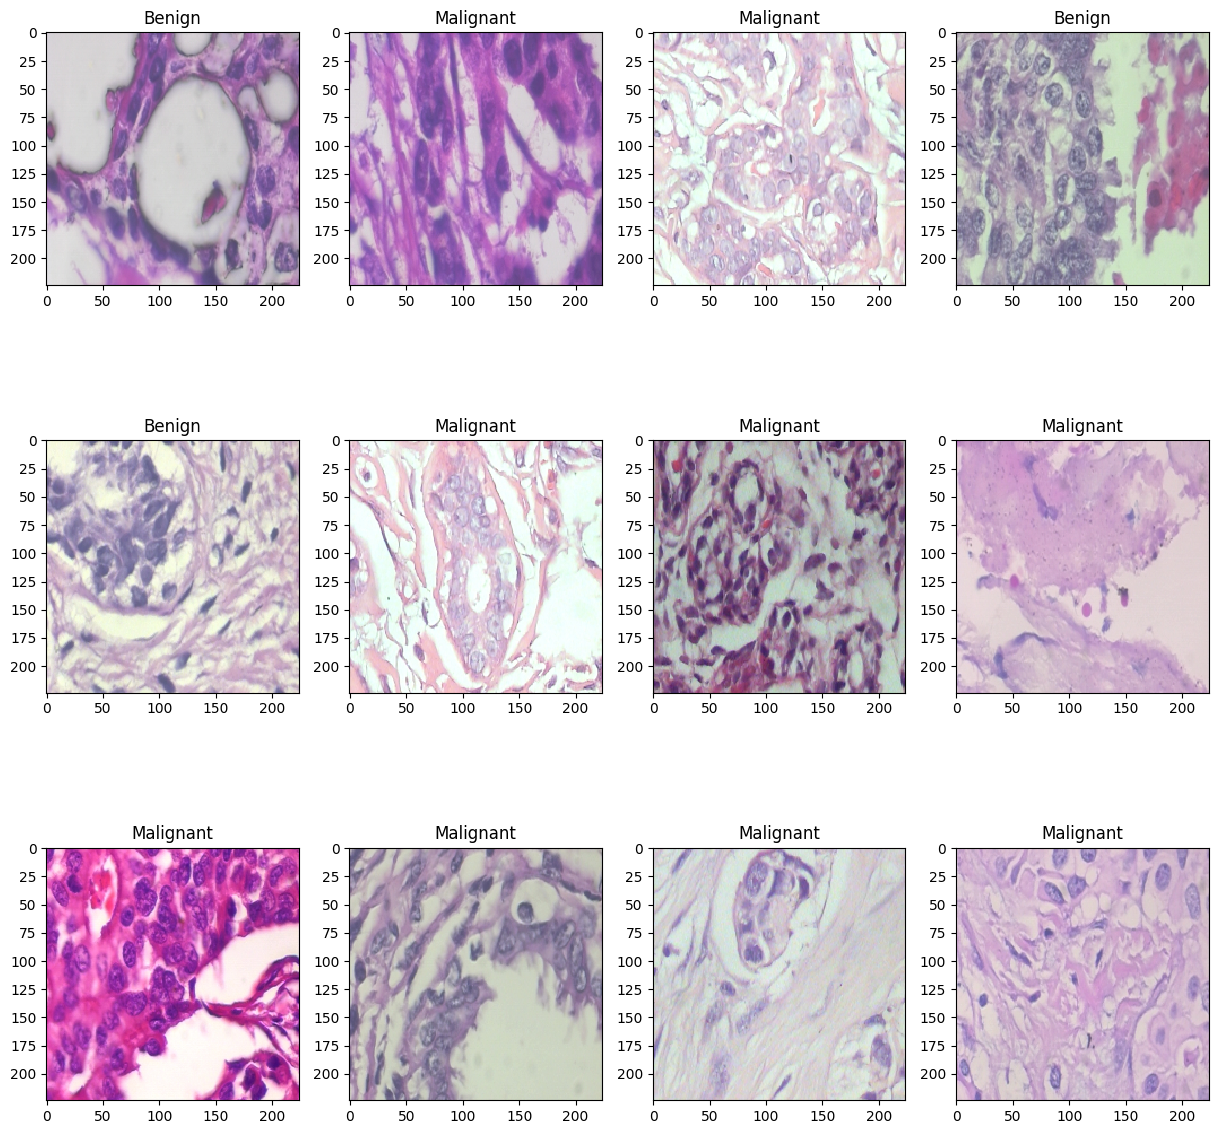

In [ ]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
         rotation_range = 90,
         horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

## Configure the hyperparameters

In [ ]:
input_shape = (224, 224, 3)
num_classes = 2
learning_rate = 0.001
weight_decay = 0.01
label_smoothing_factor = 0.1

batch_size = 32
num_epochs = 20
image_size = 224 # We'll resize input images to this size
patch_size = 16 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [ 2048, 1024]  # Size of the dense layers of the final classifier



## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 224 X 224
Patch size: 14 X 14
Patches per image: 256
Elements per patch: 588


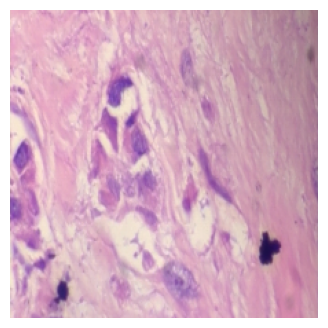

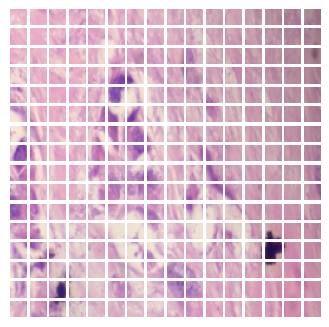

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    model.summary()
    return model


In [ ]:
from tensorflow.keras.optimizers import Adam, SGD


## Compile, train, and evaluate the mode

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow import keras
import time

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 3)          7         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_2 (Patches)         (None, None, 588)            0         ['data_augmentation[1][0]']   
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 256, 64)              54080     ['patches_2[0][0]']     

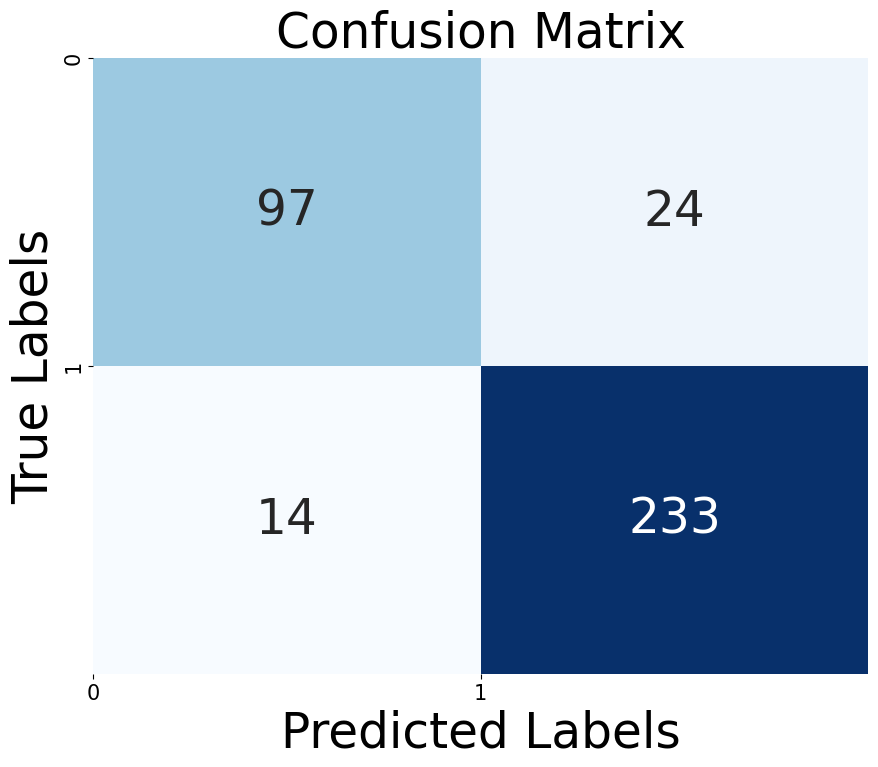

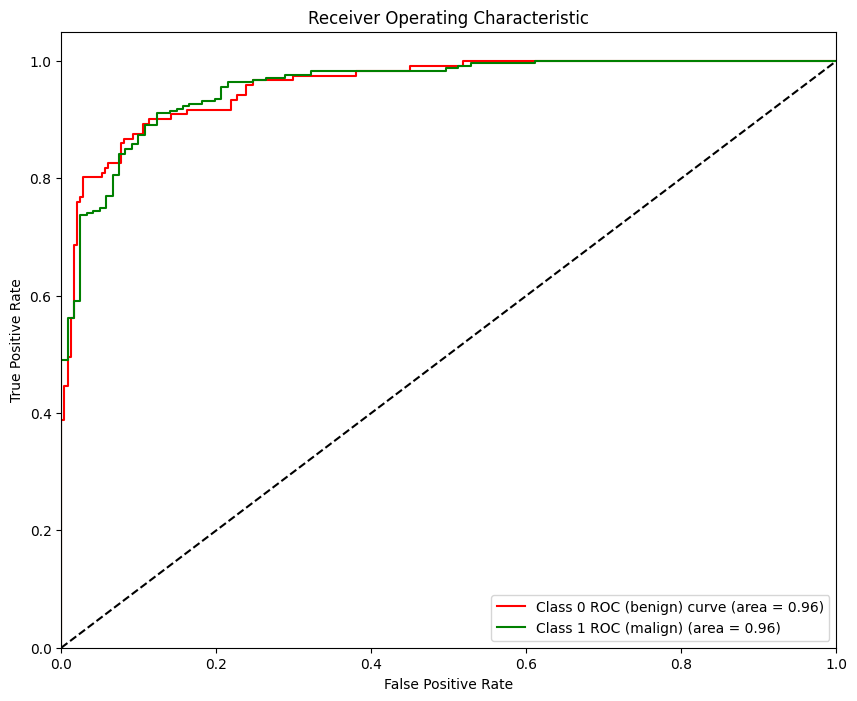

Precision: [0.87387387 0.90661479]
Sensitivity: [0.80165289 0.94331984]
Specificity: [0.94331984 0.80165289]
AUC (Class 0): 0.9582427142235754
AUC (Class 1): 0.9567705022250477
Mean Precision: 0.8902443299330458
Mean Sensitivity: 0.8724863653093318
Mean Specificity: 0.8724863653093318
AUC: 0.9567705022250477
F1 Score: 0.8804050355774493
Mean AUC (Class 0): 0.9582427142235754
Mean AUC (Class 1): 0.9567705022250477


In [ ]:


def run_experiment(model, X_train, Y_train, X_test, Y_test, num_epochs, batch_size, num_classes):
    optimizer = 'AdamaX'

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    checkpoint_filepath = "/content/drive/MyDrive/SAVE"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    start_time = time.time()  # Record the start time
    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    end_time = time.time()  # Record the end time

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Calculate total training time
    total_training_time = end_time - start_time

    # Calculate average training time per epoch
    avg_training_time_per_epoch = total_training_time / num_epochs

    # Print the training times
    print("Total Training Time (s):", total_training_time)
    print("Average Training Time per Epoch (s):", avg_training_time_per_epoch)

    # Get predicted probabilities for test data
    Y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    # Calculate Precision, Sensitivity, and Specificity
    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)

    precision = true_positives / (true_positives + false_positives)
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)


    # Calculate AUC
    y_test_labels = np.argmax(Y_test, axis=1)
    y_pred_probabilities = Y_pred[:, 1]  # Assuming binary classification, adjust accordingly
    auc = roc_auc_score(y_test_labels, y_pred_probabilities)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

    # Calculate AUC for class 0
    fpr_0, tpr_0, _ = roc_curve(Y_test[:, 0], Y_pred[:, 0])
    auc_0 = roc_auc_score(Y_test[:, 0], Y_pred[:, 0])

    # Calculate AUC for class 1
    fpr_1, tpr_1, _ = roc_curve(Y_test[:, 1], Y_pred[:, 1])
    auc_1 = roc_auc_score(Y_test[:, 1], Y_pred[:, 1])

    # Plot confusion matrix
    classes = range(num_classes)  # Replace with your actual class labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 35})
    plt.title("Confusion Matrix", size=35)
    plt.xlabel("Predicted Labels", size=35)
    plt.ylabel("True Labels", size=35)
    plt.xticks(ticks=classes, labels=classes, size=15)
    plt.yticks(ticks=classes, labels=classes, size=15)
    plt.show()

    # Plot ROC curve for both classes
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_0, tpr_0, color='red', label='Class 0 ROC (benign) curve (area = %0.2f)' % auc_0)
    plt.plot(fpr_1, tpr_1, color='green', label='Class 1 ROC (malign) (area = %0.2f)' % auc_1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Print Precision, Sensitivity, Specificity, and AUC
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("AUC (Class 0):", auc_0)
    print("AUC (Class 1):", auc_1)

    # Print Mean Precision, Sensitivity, Specificity, and AUC
    print("Mean Precision:", np.mean(precision))
    print("Mean Sensitivity:", np.mean(sensitivity))
    print("Mean Specificity:", np.mean(specificity))
    print("AUC:", np.mean(auc))
    print("F1 Score:", np.mean(f1))

    print("Mean AUC (Class 0):", np.mean(auc_0))
    print("Mean AUC (Class 1):", np.mean(auc_1))



    return history

# Create your VIT classifier
vit_classifier = create_vit_classifier()  # Define create_vit_classifier() as needed
# Define X_train, Y_train, X_test, Y_test, num_epochs, batch_size, num_classes as needed
history = run_experiment(vit_classifier, X_train, Y_train, X_test, Y_test, num_epochs, batch_size, num_classes)





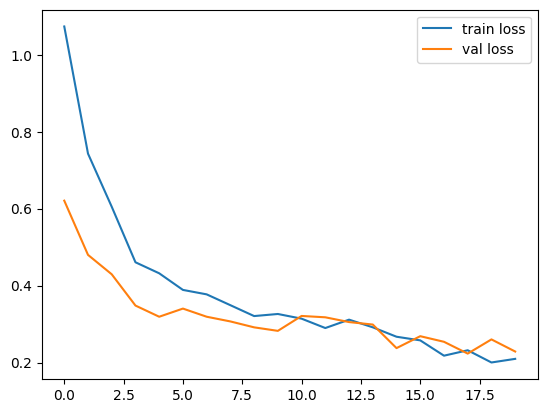

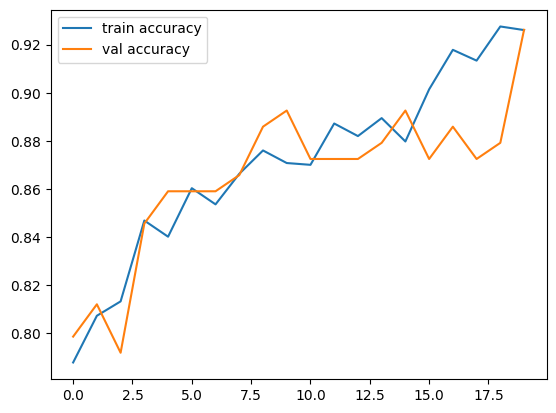

<Figure size 640x480 with 0 Axes>

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')